In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import xarray as xr
import numpy as np
import pandas as pd

from lib import ncep_r1
# from algs.fft import power_spectrum
from scipy import fftpack

%matplotlib inline
import matplotlib.pyplot as plt

import multiprocessing as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def load(product, ismean, params):
    if ismean:
        return ncep_r1.dailyavg_ltm(product, params)
    else:
        return ncep_r1.dailyavg(product, params)

In [5]:
params = {
    'pressure_level': 500,
    'year': range(1970, 2019),
    'area': '70/190/45/225'
}
    
pool = mp.Pool(2)
hgt, hgt_mean = pool.starmap(load, [
    ['pressure/hgt', False, params], 
    ['pressure/hgt', True, params],
])

/Users/jitang/anaconda/envs/storm_analysis_env/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)
/Users/jitang/anaconda/envs/storm_analysis_env/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Combining data from years for pressure/hgt


AttributeError: 'CFTimeIndex' object has no attribute '_cache'

In [5]:
firsthalf = hgt.sel(time=np.in1d(hgt['time.year'], range(1970, 1995)))
secondhalf = hgt.sel(time=np.in1d(hgt['time.year'], range(1995, 2019)))

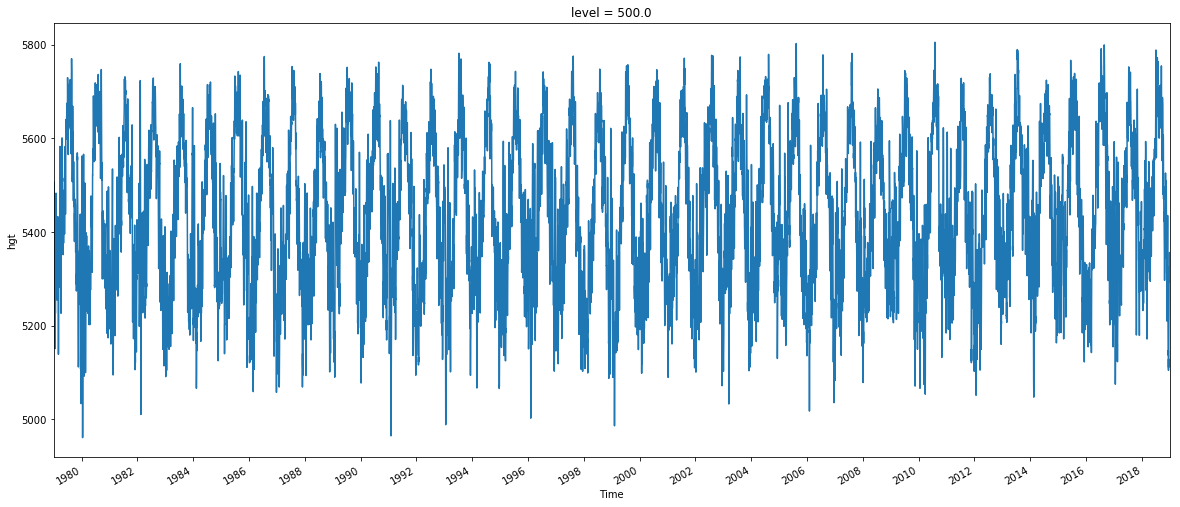

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
selection = hgt.sel(time=np.in1d(hgt['time.year'], range(1979, 2019)))
selection.mean(['lon', 'lat']).hgt.plot(ax=ax)
ax.set_xlim('1979-01-01', '2018-12-31')

import matplotlib.dates as mdates
years = mdates.YearLocator(2)
ax.xaxis.set_major_locator(years)

In [58]:
from scipy.signal import periodogram
hgt_timeseries = hgt.mean(['lon', 'lat'])
freq, psd = periodogram(hgt_timeseries.hgt, fs=365)

(0.01, 10000000.0)

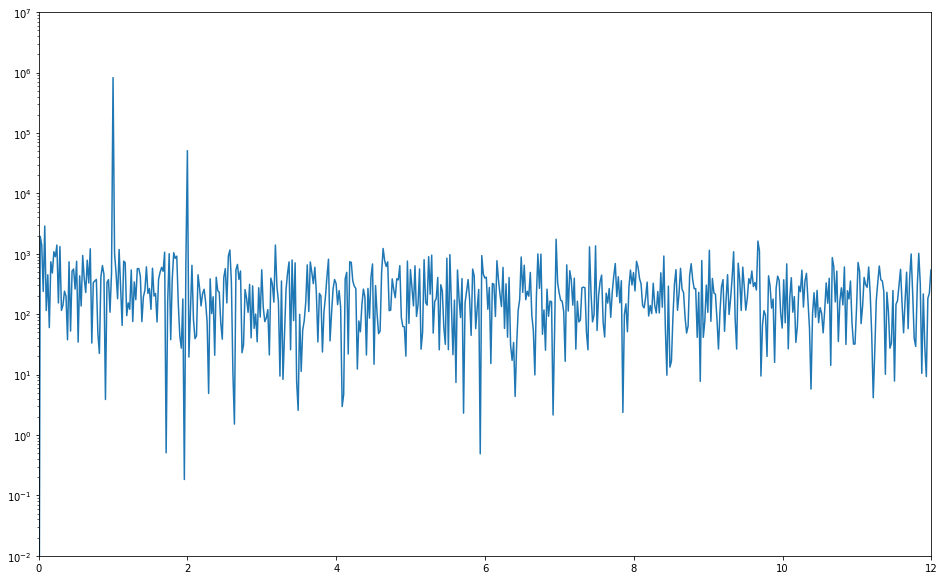

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.semilogy(freq, psd)
ax.set_xlim(0, 12)
ax.set_ylim(1e-2, 1e7)

In [211]:
from scipy import fftpack
sig_fft = fftpack.fft(hgt_timeseries.hgt)
sample_freq = fftpack.fftfreq(hgt_timeseries.hgt.size, 1/365)
sig_fft[(np.abs(sample_freq) < 1.4) | (np.abs(sample_freq) > 3)] = 0
hgt_band = np.real(fftpack.ifft(sig_fft))

In [212]:
sig_fft = fftpack.fft(hgt_timeseries.hgt)
sample_freq = fftpack.fftfreq(hgt_timeseries.hgt.size, 1/365)
sig_fft[(np.abs(sample_freq) < 0.8) | (np.abs(sample_freq) >= 1.4)] = 0
basic_signal = np.real(fftpack.ifft(sig_fft))

In [77]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    print(nyq, low, high)
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [149]:
filtered = butter_bandpass_filter(hgt_timeseries.hgt, 365 / 4, 365 / 1.5, fs=hgt_timeseries.hgt.size)

8948.5 0.010197239760853774 0.027192639362276734


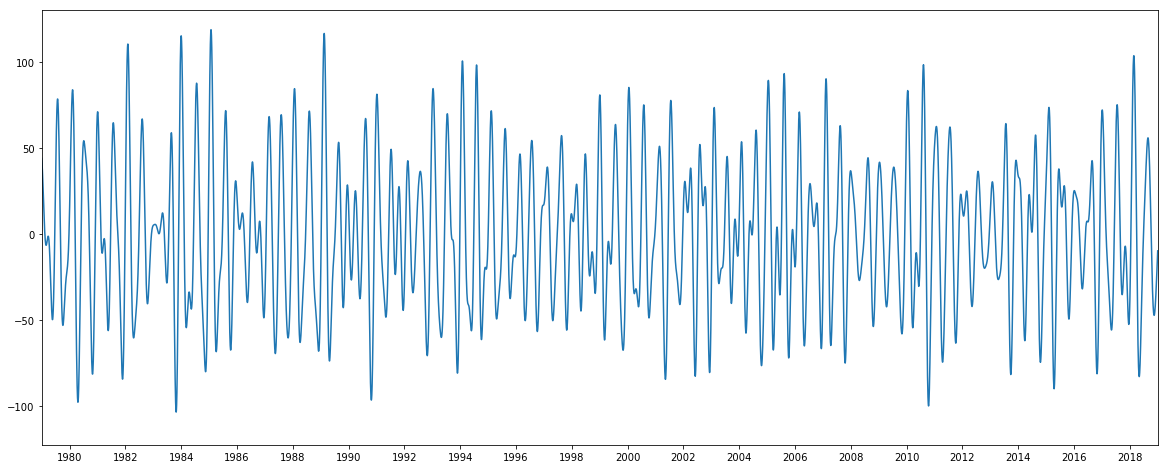

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

ax.plot(hgt_timeseries.time, hgt_band)
ax.set_xlim('1979-01-01', '2018-12-31')
# ax.set_ylim(-200, 200)

# import matplotlib.dates as mdates
years = mdates.YearLocator(2)
ax.xaxis.set_major_locator(years)

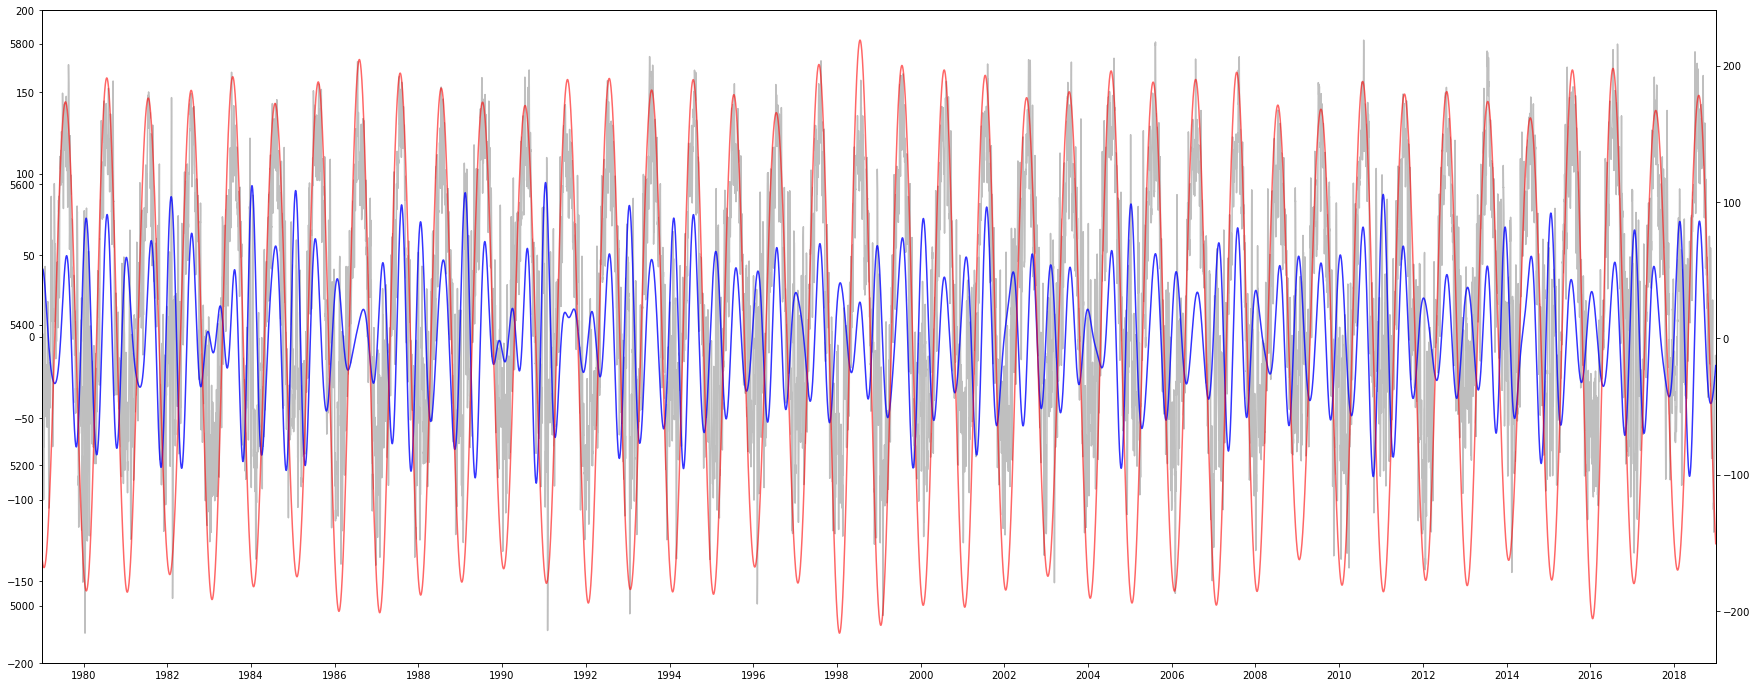

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(30, 12))
ax.plot(hgt_timeseries.time, hgt_timeseries.hgt, color='black', alpha=0.25)
ax.set_xlim('1979-01-01', '2018-12-31')
# ax.set_ylim(4900, 6000)

ax2 = ax.twinx()
ax2.plot(hgt_timeseries.time, hgt_band, color='blue', alpha=0.8)
ax2.set_ylim(-200, 200)

ax3 = ax2.twinx()
ax3.plot(hgt_timeseries.time, basic_signal, color='red', alpha=0.6)

# ax2.set_xlim('1979-01-01', '2018-12-31')
# ax2.set_ylim(-10000, 10000)

# import matplotlib.dates as mdates
years = mdates.YearLocator(2)
ax.xaxis.set_major_locator(years)